# Figure 5: Visualizing and quantitatively characterizing functional networks

In [1]:
import h5py
import itertools
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from neuropacks import ECOG
from sklearn.neighbors import KernelDensity
from uoineuro.utils import (plot_metric_summary,
                            calculate_selection_ratio)
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.coupling_utils import (check_metrics,
                                     compute_modularity,
                                     create_directed_graph,
                                     create_symmetrized_graph,
                                     read_coupling_coefs)

%matplotlib inline

## Read in model fits

In [2]:
base_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling')

In [3]:
# ac results path
ac_results_paths = [os.path.join(base_path, 'ecog/ecog_coupling.h5')]
n_ac_fits = len(ac_results_paths) 
# extract coupling coefficients
ac_baseline_ccs, ac_uoi_ccs = read_coupling_coefs(ac_results_paths, linear=True, poisson=False)

In [27]:
# consolidate v1 results
v1_results_paths = [os.path.join(base_path, 'pvc11/pvc11_monkey1_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey2_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey3_coupling.h5')]
n_v1_fits = len(v1_results_paths)
# read in v1 coupling coefficients
v1_baseline_ccs, v1_uoi_ccs = read_coupling_coefs(v1_results_paths, poisson=True, linear=False)

In [28]:
# consolidate m1 results
m1_results_paths = [os.path.join(base_path, 'nhp/nhp_indy_20160407_02_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_01_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_02_coupling.h5')]
n_m1_fits = len(m1_results_paths)
# read in m1 coupling coefficients
m1_baseline_ccs, m1_uoi_ccs = read_coupling_coefs(m1_results_paths, poisson=True, linear=False)

## Figure 5a: Functional coupling networks for electro-corticography grid

In [6]:
# read in ecog data
ecog_data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
ecog_grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
ecog = ECOG(data_path=ecog_data_path, grid_path=ecog_grid_path)

In [7]:
dead_electrodes = [0, 19, 21]

In [8]:
ecog_coupling_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling/ecog/ecog_coupling.h5')
ecog_tuning_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/tuning/ecog/ecog_tuning.h5')

In [9]:
ecog_coupling_fits = h5py.File(ecog_coupling_path, 'r')
ecog_tuning_fits = h5py.File(ecog_tuning_path, 'r')

In [10]:
ecog_baseline_ccs = np.median(ecog_coupling_fits['lasso/coupling_coefs'], axis=0)
ecog_uoi_ccs = np.median(ecog_coupling_fits['uoi_lasso_bic/coupling_coefs'], axis=0)

In [11]:
# get positions for each electrode
positions = {}

for electrode in range(ecog.n_electrodes):
    x, y = ecog.get_xy_for_electrode(electrode)
    positions[electrode] = (y, -x)

In [12]:
G_ecog_baseline, weights_dict_baseline = create_symmetrized_graph(
    coupling_coefs=ecog_baseline_ccs,
    omit_idxs=dead_electrodes,
    transform=None)
G_ecog_uoi, weights_dict_uoi = create_symmetrized_graph(
    coupling_coefs=ecog_uoi_ccs,
    omit_idxs=dead_electrodes,
    transform=None)

In [13]:
# calculate best frequencies
best_freq_baseline = np.zeros((10, 128))
best_freq_uoi = np.zeros((10, 128))

for fold in range(10):
    best_freq_baseline[fold] = calculate_best_frequencies_ecog(
        ecog_tuning_fits['lasso/tuning_coefs'][fold],
        ecog,
        return_grid=False,
        omit_idxs=dead_electrodes)

    best_freq_uoi[fold] = calculate_best_frequencies_ecog(
        ecog_tuning_fits['uoi_lasso_bic/tuning_coefs'][fold],
        ecog,
        return_grid=False,
        omit_idxs=dead_electrodes)

In [14]:
# calculate log-frequency by averaging over folds
best_log_freq_baseline = np.delete(np.log(np.mean(best_freq_baseline, axis=0)), dead_electrodes)
best_log_freq_uoi = np.delete(np.log(np.mean(best_freq_uoi, axis=0)), dead_electrodes)
# find which electrodes uoi says are untuned
uoi_untuned_indices = np.argwhere(best_log_freq_uoi == -np.inf).ravel()

In [15]:
# extract colors for nodes
baseline_color_indices = (255 * (best_log_freq_baseline - ecog.log_freq_set[0]) / (ecog.log_freq_set[-1] - ecog.log_freq_set[0])).astype('int')
baseline_colors = plt.get_cmap('Greys_r')(baseline_color_indices)
# uoi untuned electrodes need to be replaced with fuchsia color
uoi_color_indices = (255 * (best_log_freq_uoi - ecog.log_freq_set[0]) / (ecog.log_freq_set[-1] - ecog.log_freq_set[0])).astype('int')
uoi_colors = plt.get_cmap('Greys_r')(uoi_color_indices)
uoi_colors[uoi_untuned_indices] = matplotlib.colors.to_rgba('fuchsia')

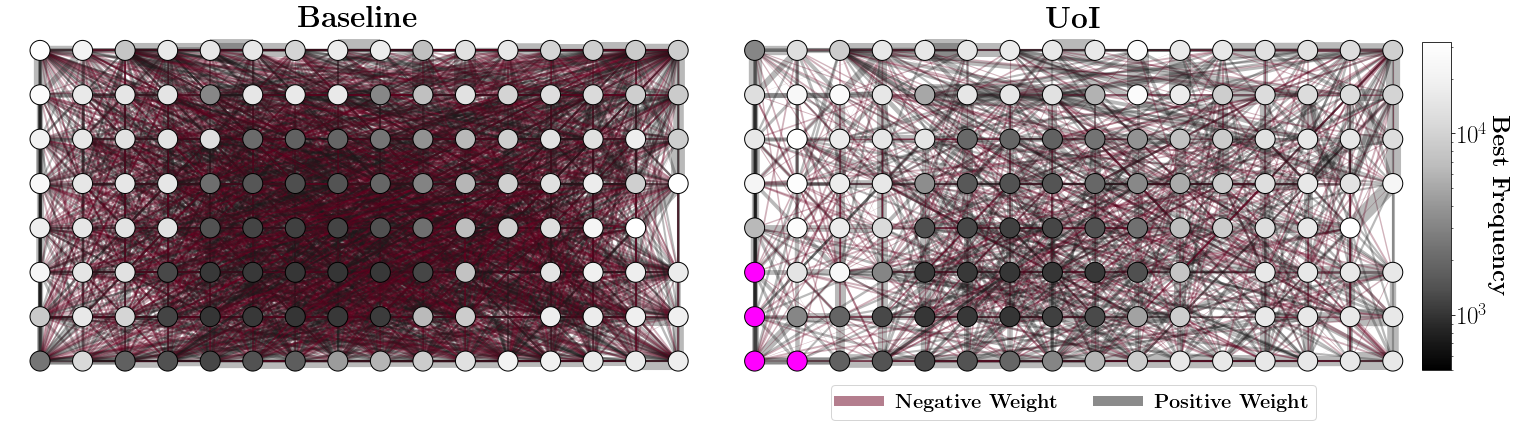

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# get edge weights as array
weight_list_baseline = np.array(list(weights_dict_baseline.values()))
weight_list_uoi = np.array(list(weights_dict_uoi.values()))

# draw baseline graph
nx.draw_networkx_nodes(
    G=G_ecog_baseline,
    pos=positions,
    node_size=400,
    nodelist=list(np.setdiff1d(np.arange(ecog.n_electrodes), dead_electrodes)),
    node_color=baseline_colors,
    edgecolors='k',
    ax=axes[0])

nx.draw_networkx_edges(
    G=G_ecog_baseline,
    pos=positions,
    width=2.0 + 20 * weight_list_baseline,
    alpha=0.30,
    edge_color=np.sign(weight_list_baseline),
    edge_cmap=plt.get_cmap('RdGy'),
    edge_vmin=-1,
    edge_vmax=1,
    ax=axes[0])

# draw UoI graph
nx.draw_networkx_nodes(
    G=G_ecog_uoi,
    pos=positions,
    node_size=400,
    nodelist=list(np.setdiff1d(np.arange(ecog.n_electrodes), dead_electrodes)),
    node_color=uoi_colors,
    edgecolors='k',
    ax=axes[1])

nx.draw_networkx_edges(
    G=G_ecog_uoi,
    pos=positions,
    width=2.0 + 20 * weight_list_uoi,
    alpha=0.30,
    edge_color=np.sign(weight_list_uoi),
    edge_cmap=plt.get_cmap('RdGy'),
    edge_vmin=-1,
    edge_vmax=1,
    ax=axes[1])

# colorbar
cax = fig.add_axes([0.99, 0.134, 0.02, 0.76])
cb = fig.colorbar(
    matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                       vmax=ecog.freq_set[-1]),
        cmap='Greys_r'),
    ticks=[1000, 10000],
    cax=cax,
    orientation='vertical')
cb.set_label(r'\textbf{Best Frequency}',
             labelpad=20,
             fontsize=24,
             rotation=270)
cb.ax.tick_params(labelsize=25)

# titles
axes[0].set_title(r'\textbf{Baseline}',
                   fontsize=30)
axes[1].set_title(r'\textbf{UoI}',
                   fontsize=30)

# edge weight legend
axes[1].plot(0, 0,
             color=plt.get_cmap('RdGy')(1),
             label=r'\textbf{Negative Weight}',
             linewidth=10,
             alpha=0.5)
axes[1].plot(0, 0,
             color=plt.get_cmap('RdGy')(255),
             label=r'\textbf{Positive Weight}',
             linewidth=10,
             alpha=0.5)
lgd = axes[1].legend(
    loc='lower center', bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    prop={'size': 20})

# stylistic changes to plot
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
#plt.savefig('ecog_coupling_grid.png', bbox_inches='tight')
plt.show()

## Figure 5b-c: V1 and M1 networks placed in communities and visualized with edge bundling

### Edge bundling visualization

These plots can be found in the `community_detect_plots.ipynb` in the `notebooks` directory. They are saved directly to file and thus are not included here. Furthermore, these plots require the `graph_tool` package to be visualized, which cannot be installed with Anaconda.

### Legends

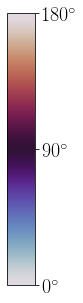

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(0.5, 5))

cmap = plt.get_cmap('twilight')
norm = matplotlib.colors.Normalize(0.0, np.pi)

cb = fig.colorbar(mappable=matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=ax)
cb.set_ticks([0, np.pi / 2, np.pi])
cb.set_ticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$'])
plt.savefig('vertical_180.pdf', bbox_inches='tight')

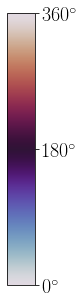

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(0.5, 5))

cmap = plt.get_cmap('twilight')
norm = matplotlib.colors.Normalize(0.0, 2 * np.pi)

cb = fig.colorbar(mappable=matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=ax)
cb.set_ticks([0, np.pi, 2 * np.pi])
cb.set_ticklabels([r'$0^{\circ}$', r'$180^{\circ}$', r'$360^{\circ}$'])
plt.savefig('vertical_360.pdf', bbox_inches='tight')

## Figure 5d-f: Characterizing functional networks with graph metrics

### Create graphs

In [29]:
# concatenate coupling coefficients
baseline_ccs = ac_baseline_ccs + v1_baseline_ccs + m1_baseline_ccs
uoi_ccs = ac_uoi_ccs + v1_uoi_ccs + m1_uoi_ccs

In [30]:
# create graphs
baseline_sgraphs = [create_symmetrized_graph(baseline_cc)[0]
                    for baseline_cc in baseline_ccs]
uoi_sgraphs = [create_symmetrized_graph(uoi_cc)[0]
               for uoi_cc in uoi_ccs]
baseline_dgraphs = [create_directed_graph(baseline_cc)
                    for baseline_cc in baseline_ccs]
uoi_dgraphs = [create_directed_graph(uoi_cc)
               for uoi_cc in uoi_ccs]

In [31]:
s_graphs = {
    'ac_baseline': baseline_sgraphs[0],
    'vc_monkey1_baseline': baseline_sgraphs[1],
    'vc_monkey2_baseline': baseline_sgraphs[2],
    'vc_monkey3_baseline': baseline_sgraphs[3],
    'mc_monkey1_baseline': baseline_sgraphs[4],
    'mc_monkey2_baseline': baseline_sgraphs[5],
    'mc_monkey3_baseline': baseline_sgraphs[6],
    'ac_uoi': uoi_sgraphs[0],
    'vc_monkey1_uoi': uoi_sgraphs[1],
    'vc_monkey2_uoi': uoi_sgraphs[2],
    'vc_monkey3_uoi': uoi_sgraphs[3],
    'mc_monkey1_uoi': uoi_sgraphs[4],
    'mc_monkey2_uoi': uoi_sgraphs[5],
    'mc_monkey3_uoi': uoi_sgraphs[6],
}

In [32]:
d_graphs = {
    'ac_baseline': baseline_dgraphs[0],
    'vc_monkey1_baseline': baseline_dgraphs[1],
    'vc_monkey2_baseline': baseline_dgraphs[2],
    'vc_monkey3_baseline': baseline_dgraphs[3],
    'mc_monkey1_baseline': baseline_dgraphs[4],
    'mc_monkey2_baseline': baseline_dgraphs[5],
    'mc_monkey3_baseline': baseline_dgraphs[6],
    'ac_uoi': uoi_dgraphs[0],
    'vc_monkey1_uoi': uoi_dgraphs[1],
    'vc_monkey2_uoi': uoi_dgraphs[2],
    'vc_monkey3_uoi': uoi_dgraphs[3],
    'mc_monkey1_uoi': uoi_dgraphs[4],
    'mc_monkey2_uoi': uoi_dgraphs[5],
    'mc_monkey3_uoi': uoi_dgraphs[6],
}

### In- and out-degree distributions

In [10]:
in_degrees = {
    key: np.array(list(dict(val.in_degree()).values()))
    for key, val in d_graphs.items()
}

out_degrees = {
    key: np.array(list(dict(val.out_degree()).values()))
    for key, val in d_graphs.items()
}

# concatenate degree distributions for brain regions with multiple datasets
for degrees in [in_degrees, out_degrees]:
    degrees['vc_baseline'] = np.concatenate(
        (degrees['vc_monkey1_baseline'],
         degrees['vc_monkey2_baseline'],
         degrees['vc_monkey3_baseline'])
    )
    degrees['vc_uoi'] = np.concatenate(
        (degrees['vc_monkey1_uoi'],
         degrees['vc_monkey2_uoi'],
         degrees['vc_monkey3_uoi'])
    )
    degrees['mc_baseline'] = np.concatenate(
        (degrees['mc_monkey1_baseline'],
         degrees['mc_monkey2_baseline'],
         degrees['mc_monkey3_baseline'])
    )
    degrees['mc_uoi'] = np.concatenate(
        (degrees['mc_monkey1_uoi'],
         degrees['mc_monkey2_uoi'],
         degrees['mc_monkey3_uoi'])
    )

In [11]:
# apply kernel density estimator to distributions
in_degree_densities = {}
out_degree_densities = {}

bandwidths = [4.0, 5.0, 8.0]
baselines = ['ac_baseline', 'vc_baseline', 'mc_baseline']
uois = ['ac_uoi', 'vc_uoi', 'mc_uoi']

for bandwidth, baseline, uoi in zip(bandwidths, baselines, uois):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(in_degrees[baseline].reshape(-1, 1))
    in_degree_densities[baseline] = kde

    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(in_degrees[uoi].reshape(-1, 1))
    in_degree_densities[uoi] = kde

    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(out_degrees[baseline].reshape(-1, 1))
    out_degree_densities[baseline] = kde

    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(in_degrees[uoi].reshape(-1, 1))
    out_degree_densities[uoi] = kde

### Modularity

In [33]:
# calculate modularities
modularities = {
    key: compute_modularity(val)
    for key, val in d_graphs.items()
}

### Small-worldness

In [13]:
# small-worldness was calculated separately; read in the values
small_world = h5py.File(os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling/graphs/small_world.h5'))

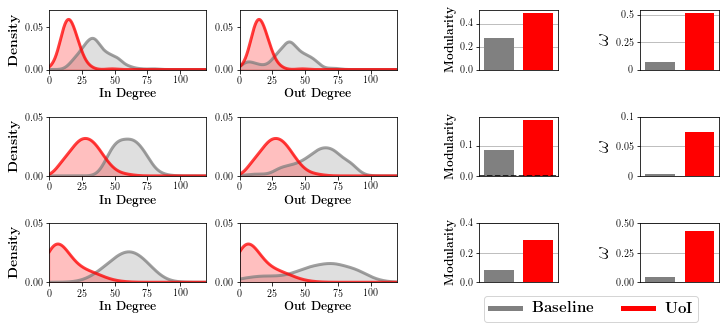

In [14]:
fig, axes = plt.subplots(3, 6, figsize=(12, 5),
                         gridspec_kw={'width_ratios': [1, 1, 0.1, 0.5, 0.1, 0.5]})

bins = np.linspace(0, 100, 20)
x_samples = np.linspace(0, 120, 1000)[..., np.newaxis]
colors = ['gray','red']
datasets = ['ac', 'vc', 'mc']

for idx, dataset in enumerate(datasets):
    in_ax = axes[idx, 0]
    out_ax = axes[idx, 1]
    baseline_key = dataset + '_baseline'
    uoi_key = dataset + '_uoi'
    
    for ax, degree_density in zip([in_ax, out_ax], [in_degree_densities, out_degree_densities]):
        for key, color in zip([baseline_key, uoi_key], colors):
            ax.plot(
                x_samples,
                np.exp(degree_density[key].score_samples(x_samples)),
                color=color,
                alpha=0.75,
                linewidth=3)
            ax.fill_between(
                x_samples.ravel(),
                np.exp(degree_density[key].score_samples(x_samples)),
                color=color,
                alpha=0.25)

for ax in axes[:, :2].ravel():
    ax.tick_params(labelsize=10)
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 0.05])
    ax.set_yticks([0, 0.05])
    
axes[0, 0].set_ylim([0, 0.07])
axes[0, 1].set_ylim([0, 0.07])
    
# modularities
axes[0, 3].bar(x=[0, 1],
               height=[modularities['ac_baseline'], modularities['ac_uoi']],
               color=['gray', 'red'],
               width=0.75)

axes[1, 3].bar(x=[0, 1],
               height=[np.mean([modularities['vc_monkey1_baseline'],
                                modularities['vc_monkey2_baseline'],
                                modularities['vc_monkey3_baseline']]),
                       np.mean([modularities['vc_monkey1_uoi'],
                                modularities['vc_monkey2_uoi'],
                                modularities['vc_monkey3_uoi']])],
               color=['gray', 'red'],
               width=0.75)
axes[2, 3].bar(x=[0, 1],
               height=[np.mean([modularities['mc_monkey1_baseline'],
                                modularities['mc_monkey2_baseline'],
                                modularities['mc_monkey3_baseline']]),
                       np.mean([modularities['mc_monkey1_uoi'],
                                modularities['mc_monkey2_uoi'],
                                modularities['mc_monkey3_uoi']])],
               color=['gray', 'red'],
               width=0.75)

axes[1, 3].axhline(0, color='k', linestyle='--')

for ax in axes[:, 3]:
    ax.set_xlim([-0.5, 1.5])
    ax.tick_params(labelsize=10)
    ax.set_xticks([])

axes[0, 3].set_yticks([0, 0.2, 0.4])
axes[1, 3].set_yticks([0, 0.1])
axes[2, 3].set_yticks([0, 0.2, 0.4])

# small-worldness
axes[0, 5].bar(x=[0, 1],
               height=[small_world['ac_baseline'][:][0], small_world['ac_uoi'][:][0]],
               color=['gray', 'red'],
               width=0.75)

axes[1, 5].bar(x=[0, 1],
               height=[np.mean([small_world['vc_baseline'][:]]),
                       np.mean([small_world['vc_uoi'][:]])],
               color=['gray', 'red'],
               width=0.75)
axes[2, 5].bar(x=[0, 1],
               height=[np.mean([small_world['mc_baseline'][:]]),
                       np.mean([small_world['mc_uoi'][:]])],
               color=['gray', 'red'],
               width=0.75)

for ax in axes[:, 5]:
    ax.set_xlim([-0.5, 1.5])
    ax.tick_params(labelsize=10)
    ax.set_xticks([])

axes[0, 5].set_yticks([0, 0.25, 0.5])
axes[0, 5].set_yticklabels([0, 0.25, 0.5])
axes[1, 5].set_yticks([0, 0.05, 0.1])
axes[1, 5].set_yticklabels([0, 0.05, 0.1])
axes[2, 5].set_yticks([0, 0.25, 0.5])

for ax in axes[:, 0]:
    ax.set_xlabel(r'\textbf{In Degree}', fontsize=12)
    
for ax in axes[:, 1]:
    ax.set_xlabel(r'\textbf{Out Degree}', fontsize=12)

for ax in axes[:, 3]:
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(r'\textbf{Modularity}', fontsize=12)
    
for ax in axes[:, 5]:
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(r'$\omega$', fontsize=20)
    
for ax in axes[:, 2]:
    ax.axis('off')
for ax in axes[:, 4]:
    ax.axis('off')

axes[0, 0].set_ylabel(r'\textbf{Density}', fontsize=14, labelpad=5)
axes[1, 0].set_ylabel(r'\textbf{Density}', fontsize=14, labelpad=5)
axes[2, 0].set_ylabel(r'\textbf{Density}', fontsize=14, labelpad=5)

axes[2, 4].plot([], [], color='gray', label=r'\textbf{Baseline}', linewidth=5)
axes[2, 4].plot([], [], color='r', label=r'\textbf{UoI}', linewidth=5)
axes[2, 4].legend(
    loc='center',
    bbox_to_anchor=(0, -0.45),
    ncol=2,
    prop={'size': 15})
plt.subplots_adjust(hspace=0.80, wspace=0.4)
#plt.savefig('graph_analysis.pdf', bbox_inches='tight')